In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertForTokenClassification, Trainer, TrainingArguments
from transformers import AdamW, pipeline, BertTokenizerFast
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from tqdm import tqdm
import random
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import os

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
PyTorch version: 2.5.1+cu118
GPU: NVIDIA GeForce RTX 4070 Ti


In [3]:
# Set logging level to ERROR to suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

In [4]:
# Load the dataset
dataset_path = "data/annotated_100.csv"
data = pd.read_csv(dataset_path)

In [5]:
# Display the first few rows of the dataset
print("First rows of the dataset:")
data.head()

First rows of the dataset:


,sentence,annotation
0,Chimborazo in the ocean and even whole ranges ...,B-MOUNT O O O O O O O O O O O O O O O O O O O ...
1,I would rather go to the Elbrus than to the be...,O O O O O O B-MOUNT O O O O
2,"Which do you like better, the sea or the Olympus?",O O O O O O O O O B-MOUNT
3,Some people like the sea; others prefer the An...,O O O O O O O O B-MOUNT
4,We watched the sun setting behind the Annapurna.,O O O O O O O B-MOUNT


In [6]:
# Check for missing values in the dataset
print("\nMissing values check:")
data.isnull().sum()


Missing values check:


sentence      0
annotation    0
dtype: int64

In [7]:
# Check the dataset size (number of rows and columns)
print("\nDataset size:")
data.shape


Dataset size:


(100, 2)

In [8]:
# Extract and display unique annotations
print("\nUnique values in the 'annotation' column:")
unique_annotations = data['annotation'].apply(lambda x: x.split()).explode().unique()
print(unique_annotations)


Unique values in the 'annotation' column:
['B-MOUNT' 'O' 'I-MOUNT']


In [9]:
# Split sentences and annotations for further processing
sentences = data['sentence'].values
annotations = data['annotation'].apply(lambda x: x.split()).values

In [10]:
# Define the augmentation function
def augment_data(mountain_list, base_sentences, num_augmentations=100):
    augmented_sentences = []
    augmented_labels = []

    for _ in range(num_augmentations):
        mountain = random.choice(mountain_list)  # Random mountain name
        sentence = random.choice(base_sentences).format(mountain)
        
        # Generate labels for multi-word entities
        tokens = mountain.split()
        labels = ["B-MOUNT"] + ["I-MOUNT"] * (len(tokens) - 1)
        
        sentence_tokens = sentence.split()
        sentence_labels = []
        for token in sentence_tokens:
            if token in tokens:
                index = tokens.index(token)
                sentence_labels.append(labels[index])
            else:
                sentence_labels.append("O")
        
        augmented_sentences.append(sentence)
        augmented_labels.append(sentence_labels)
    
    return augmented_sentences, augmented_labels

# Define mountains and base sentences for augmentation
mountains = [
    "Mount Kilimanjaro", "Mount McKinley", "Rocky Mountains",
    "Blue Ridge Mountains", "Cascade Range", "Great Smoky Mountains"
]
base_sentences = [
    "I climbed {} last year.",
    "{} are breathtaking.",
    "The view from {} is spectacular.",
    "I recently visited {} with my friends.",
    "{} is a famous destination for hikers."
]

In [11]:
# Generate augmented data
augmented_sentences, augmented_annotations = augment_data(
    mountain_list=mountains,
    base_sentences=base_sentences,
    num_augmentations=100
)

# Combine original sentences with augmented sentences
sentences = list(sentences) + augmented_sentences
annotations = list(annotations) + augmented_annotations

In [12]:
# Tokenize annotations by splitting each annotation string into a list of tokens
tokenized_annotations = annotations

In [13]:
# Split the dataset into training and testing sets
train_sentences, test_sentences, train_annotations, test_annotations = train_test_split(
    sentences, annotations, test_size=0.2, random_state=42
)

In [14]:
# Display the number of samples in the training and testing sets
print("Number of training samples:", len(train_sentences))
print("Number of testing samples:", len(test_sentences))

Number of training samples: 160
Number of testing samples: 40


In [15]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [16]:
# Function to tokenize sentences and align labels
def tokenize_and_align_labels(sentences, annotations, tokenizer):
    tokenized_inputs = tokenizer(
        sentences,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt",
        is_split_into_words=False
    )

    aligned_labels = []
    for i, label in enumerate(annotations):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_id = None
        label_ids = []

        for word_id in word_ids:
            if word_id is None:  # Special tokens ([CLS], [SEP], etc.)
                label_ids.append(-100)
            elif word_id < len(label):  # Ensure word_id is within bounds
                if word_id != previous_word_id:  # First token of a word
                    label_ids.append(label[word_id])  # Assign original label
                else:  # Subtokens
                    # Repeat the label for subwords
                    sub_label = "I-MOUNT" if label[previous_word_id] == "B-MOUNT" else label[previous_word_id]
                    label_ids.append(sub_label)
            else:
                label_ids.append(-100)

            previous_word_id = word_id

        aligned_labels.append(label_ids)

    return tokenized_inputs, aligned_labels

In [17]:
# Tokenize and align labels for training and testing data
train_inputs, train_labels = tokenize_and_align_labels(train_sentences, train_annotations, tokenizer)
test_inputs, test_labels = tokenize_and_align_labels(test_sentences, test_annotations, tokenizer)

In [18]:
# Check if the number of tokens matches the number of labels for training data
for i, labels in enumerate(train_labels):
    tokens = train_inputs.encodings[i].tokens  # Get the tokens for the i-th sentence
    if len(labels) != len(tokens):  # Compare number of labels with number of tokens
        print(f"Mismatch in training sample {i}: {len(labels)} labels vs {len(tokens)} tokens")

In [19]:
# Check if the number of tokens matches the number of labels for testing data
for i, labels in enumerate(test_labels):
    tokens = test_inputs.encodings[i].tokens  # Get the tokens for the i-th sentence
    if len(labels) != len(tokens):  # Compare number of labels with number of tokens
        print(f"Mismatch in testing sample {i}: {len(labels)} labels vs {len(tokens)} tokens")

In [20]:
# Example debugging for tokenization and label alignment
example_index = 1  # Change this index to check different examples

# Get tokens and labels for the example
tokens = train_inputs.encodings[example_index].tokens  # Use .tokens to get token list
labels = train_labels[example_index]

In [21]:
# Check alignment visually
for token, label in zip(tokens[:15], labels[:15]):
    print(f"{token:15} --> {label}")

[CLS]           --> -100
I               --> O
climbed         --> O
Rocky           --> B-MOUNT
Mountains       --> I-MOUNT
last            --> O
year            --> O
.               --> -100
[SEP]           --> -100
[PAD]           --> -100
[PAD]           --> -100
[PAD]           --> -100
[PAD]           --> -100
[PAD]           --> -100
[PAD]           --> -100


In [22]:
# Define a custom dataset for token classification
class NERDataset(Dataset):
    def __init__(self, inputs, labels, label2id):
        self.inputs = inputs
        self.labels = labels
        self.label2id = label2id  # Map for converting labels to IDs

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        label_ids = [
            self.label2id[label] if label != -100 else -100  # Convert label to ID, ignore -100
            for label in self.labels[idx]
        ]
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx],
            "labels": torch.tensor(label_ids, dtype=torch.long)  # Create tensor from label IDs
        }

In [23]:
# Define label-to-ID mapping
label2id = {"O": 0, "B-MOUNT": 1, "I-MOUNT": 2}

# Prepare datasets
train_dataset = NERDataset(train_inputs, train_labels, label2id)
test_dataset = NERDataset(test_inputs, test_labels, label2id)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [24]:
# Define the model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=3,
    id2label={0: "O", 1: "B-MOUNT", 2: "I-MOUNT"},
    label2id={"O": 0, "B-MOUNT": 1, "I-MOUNT": 2}
)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Define class weights for imbalanced data
tag_counts = {'O': 10153, 'B-MOUNT': 82, 'I-MOUNT': 5}
total = sum(tag_counts.values())
weights = torch.tensor([
    total / tag_counts['O'],          # Weight for "O"
    total / tag_counts['B-MOUNT'],    # Weight for "B-MOUNT"
    total / tag_counts['I-MOUNT'],    # Weight for "I-MOUNT"
]).to(device)

In [27]:
# Use weighted loss
loss_function = CrossEntropyLoss(weight=weights)

# Prepare optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Move model to device (GPU if available)
model.to(device)

C:\Users\Anastasiia\anaconda3\envs\Quantum-NER\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [28]:
# List to store loss for each epoch
epoch_losses = []

# Training loop
model.train()
for epoch in range(50):  # Adjust the number of epochs
    print(f"Epoch {epoch + 1}")
    total_loss = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        # Compute loss
        loss = loss_function(logits.view(-1, model.config.num_labels), labels.view(-1))
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Store the average loss for the epoch
    average_loss = total_loss / len(train_dataloader)
    epoch_losses.append(average_loss)
    print(f"Average loss for epoch {epoch + 1}: {average_loss}")

Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.50it/s]


Average loss for epoch 1: 0.34060976542532445
Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.74it/s]


Average loss for epoch 2: 0.1169272817671299
Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.29it/s]


Average loss for epoch 3: 0.07661594226956367
Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.98it/s]


Average loss for epoch 4: 0.03920735977590084
Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.07it/s]


Average loss for epoch 5: 0.019616072112694383
Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.06it/s]


Average loss for epoch 6: 0.012182748690247536
Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.83it/s]


Average loss for epoch 7: 0.010295207949820907
Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.02it/s]


Average loss for epoch 8: 0.008216856908984483
Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.21it/s]


Average loss for epoch 9: 0.007557495834771544
Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.88it/s]


Average loss for epoch 10: 0.006271739734802395
Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.12it/s]


Average loss for epoch 11: 0.005457033711718395
Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.12it/s]


Average loss for epoch 12: 0.004194838198600337
Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.13it/s]


Average loss for epoch 13: 0.003556068439502269
Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.76it/s]


Average loss for epoch 14: 0.0033323275129077956
Epoch 15


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.26it/s]


Average loss for epoch 15: 0.0028346427949145435
Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.75it/s]


Average loss for epoch 16: 0.002512651638244279
Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.05it/s]


Average loss for epoch 17: 0.0020517712502623906
Epoch 18


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.63it/s]


Average loss for epoch 18: 0.0015814480997505599
Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.58it/s]


Average loss for epoch 19: 0.0015068597749632318
Epoch 20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.19it/s]


Average loss for epoch 20: 0.0013106745565892198
Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.57it/s]


Average loss for epoch 21: 0.001517254995997064
Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.70it/s]


Average loss for epoch 22: 0.001233090778987389
Epoch 23


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.93it/s]


Average loss for epoch 23: 0.0011600778823776636
Epoch 24


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.78it/s]


Average loss for epoch 24: 0.0010090478870552033
Epoch 25


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.39it/s]


Average loss for epoch 25: 0.001035314845648827
Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.07it/s]


Average loss for epoch 26: 0.0007874953138525598
Epoch 27


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.80it/s]


Average loss for epoch 27: 0.0007541659804701339
Epoch 28


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.41it/s]


Average loss for epoch 28: 0.0007517388999985997
Epoch 29


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.17it/s]


Average loss for epoch 29: 0.0007018458833044861
Epoch 30


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


Average loss for epoch 30: 0.0010290131293004378
Epoch 31


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.14it/s]


Average loss for epoch 31: 0.026482497704273557
Epoch 32


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.31it/s]


Average loss for epoch 32: 0.01792440959252417
Epoch 33


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.16it/s]


Average loss for epoch 33: 0.004102767584845424
Epoch 34


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.33it/s]


Average loss for epoch 34: 0.001973746792646125
Epoch 35


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.38it/s]


Average loss for epoch 35: 0.0012303976167459042
Epoch 36


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.82it/s]


Average loss for epoch 36: 0.0010864078387385235
Epoch 37


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.92it/s]


Average loss for epoch 37: 0.0009555035401717759
Epoch 38


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.75it/s]


Average loss for epoch 38: 0.0008887233459972776
Epoch 39


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.22it/s]


Average loss for epoch 39: 0.0008119111633277498
Epoch 40


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.49it/s]


Average loss for epoch 40: 0.000688329192053061
Epoch 41


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.06it/s]


Average loss for epoch 41: 0.0007258724865096156
Epoch 42


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.70it/s]


Average loss for epoch 42: 0.0006297972391621443
Epoch 43


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.08it/s]


Average loss for epoch 43: 0.0007093922191415914
Epoch 44


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.68it/s]


Average loss for epoch 44: 0.0005976305234071333
Epoch 45


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.06it/s]


Average loss for epoch 45: 0.000611232557639596
Epoch 46


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.04it/s]


Average loss for epoch 46: 0.0005665286647854373
Epoch 47


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.03it/s]


Average loss for epoch 47: 0.0004997194108000258
Epoch 48


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.25it/s]


Average loss for epoch 48: 0.0005440581404400291
Epoch 49


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.23it/s]


Average loss for epoch 49: 0.0005163839432498207
Epoch 50


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.35it/s]

Average loss for epoch 50: 0.0005575233324634609


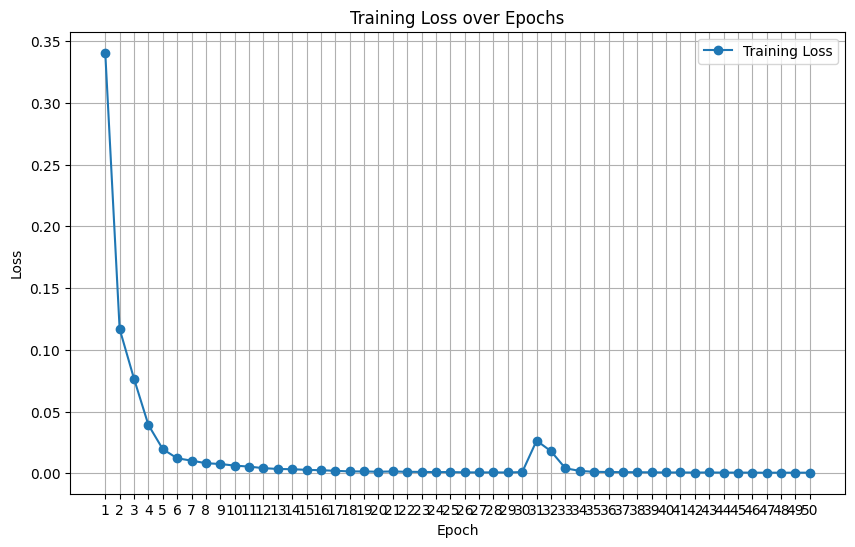

In [29]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(epoch_losses) + 1))  # Set x-axis to show each epoch
plt.legend()
plt.grid()
plt.show()

In [30]:
# Define the folder where the model should be saved
save_folder = "./ner_model"

# Check if the folder exists
if not os.path.exists(save_folder):
    print(f"Creating folder: {save_folder}")
    os.makedirs(save_folder)
else:
    print(f"Saving model into existing folder: {save_folder}")

# Save the model and tokenizer
model.save_pretrained(save_folder)
tokenizer.save_pretrained(save_folder)

print(f"Model and tokenizer saved in: {save_folder}")

Saving model into existing folder: ./ner_model
Model and tokenizer saved in: ./ner_model


In [31]:
# Define the path to the saved model
model_path = "./ner_model"

# Load the model and tokenizer
model = BertForTokenClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Create a pipeline for NER
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

In [102]:
# Define merge_subtokens function with confidence threshold
def merge_subtokens_with_threshold(predictions, confidence_threshold=0.84):
    merged_entities = []
    current_entity = None
    current_entity_score = []

    for pred in predictions:
        token = pred["word"]
        label = pred["entity"]
        score = pred["score"]

        if token.startswith("##"):
            if current_entity:
                current_entity["word"] += token[2:]  # Append subtoken
                current_entity_score.append(score)
        else:
            if current_entity:
                avg_score = sum(current_entity_score) / len(current_entity_score)
                if avg_score >= confidence_threshold:
                    current_entity["score"] = avg_score
                    merged_entities.append(current_entity)
            current_entity = {"word": token, "entity": label, "score": score}
            current_entity_score = [score]

    if current_entity:
        avg_score = sum(current_entity_score) / len(current_entity_score)
        if avg_score >= confidence_threshold:
            current_entity["score"] = avg_score
            merged_entities.append(current_entity)

    return merged_entities


In [103]:
# Test sample
test_text = "I climbed Mount Everest and visited the Alps in June."

# Get predictions
predictions = ner_pipeline(test_text)

# Merge results
merged_predictions = merge_subtokens_with_threshold(predictions)

# Display the predictions
for entity in merged_predictions:
    print(f"Entity: {entity['word']}, Label: {entity['entity']}, Score: {entity['score']:.2f}")

Entity: Mount, Label: B-MOUNT, Score: 1.00
Entity: Everest, Label: I-MOUNT, Score: 1.00
Entity: Alps, Label: B-MOUNT, Score: 0.85


In [104]:
# Test text
test_text = "I climbed Mount Kilimanjaro and Mount McKinley."

# Predictions
predictions = ner_pipeline(test_text)

# Merge results
merged_predictions = merge_subtokens_with_threshold(predictions)

# Output the results
for entity in merged_predictions:
    print(f"Entity: {entity['word']}, Label: {entity['entity']}, Score: {entity['score']:.2f}")

Entity: Mount, Label: B-MOUNT, Score: 1.00
Entity: Kilimanjaro, Label: I-MOUNT, Score: 1.00
Entity: Mount, Label: B-MOUNT, Score: 1.00
Entity: McKinley, Label: I-MOUNT, Score: 1.00


In [105]:
# Test sentences
test_sentences = [
    "Mount Everest is the tallest mountain.",
    "I hiked in the Alps and the Pyrenees last summer.",
    "Kilimanjaro is in Tanzania.",
    "This sentence does not mention a mountain.",
    "Denali, also known as Mount McKinley, is in Alaska.",
    "The Andes are a stunning mountain range in South America.",
    "I visited Table Mountain in South Africa last year.",
    "Mount Fuji is an active volcano in Japan.",
    "Rocky Mountains extend across the United States and Canada.",
    "Mount Elbrus is the highest peak in Europe."
]

# Corresponding labels
test_labels = [
    ["B-MOUNT", "I-MOUNT", "O", "O", "O", "O", "O"],
    ["O", "O", "O", "O", "B-MOUNT", "O", "O", "B-MOUNT", "O", "O", "O"],
    ["B-MOUNT", "O", "O", "O", "O"],
    ["O", "O", "O", "O", "O", "O", "O", "O"],
    ["B-MOUNT", "O", "O", "O", "B-MOUNT", "I-MOUNT", "O", "O", "O", "O", "O", "O"],
    ["O", "B-MOUNT", "O", "O", "O", "O", "O", "O", "O", "O", "O"],
    ["O", "O", "B-MOUNT", "I-MOUNT", "O", "O", "O", "O", "O", "O"],
    ["B-MOUNT", "I-MOUNT", "O", "O", "O", "O", "O", "O", "O"],
    ["B-MOUNT", "I-MOUNT", "O", "O", "O", "O", "O", "O", "O", "O"],
    ["B-MOUNT", "I-MOUNT", "O", "O", "O", "O", "O", "O", "O"]
]

This dataset includes:

- Sentences with single mountains: e.g., "Mount Everest".
- Sentences with multiple mountains: e.g., "The Alps and the Pyrenees".
- Complex sentences: e.g., "Denali, also known as Mount McKinley".
- Sentences with no mountains: e.g., "This sentence does not mention a mountain".

In [106]:
# Combine into a dataframe
test_data = pd.DataFrame({
    "sentence": test_sentences,
    "labels": [" ".join(labels) for labels in test_labels]
})

# Save to CSV
test_data.to_csv("test_dataset.csv", index=False)
print("Test dataset saved as 'test_dataset.csv'")

Test dataset saved as 'test_dataset.csv'


In [107]:
# Load the test dataset
test_data = pd.read_csv("test_dataset.csv")

# Extract sentences and true labels
test_sentences = test_data["sentence"].tolist()
test_labels = [labels.split() for labels in test_data["labels"]]

In [110]:
for sentence in test_sentences:
    # Predictions
    predictions = ner_pipeline(sentence)

    # Merge predictions with confidence filtering
    filtered_predictions = merge_subtokens_with_threshold(predictions)
    
    print(sentence)
    
    # Output results
    for entity in filtered_predictions:
        print(f"Entity: {entity['word']}, Label: {entity['entity']}, Score: {entity['score']:.2f}")

Mount Everest is the tallest mountain.
Entity: Mount, Label: B-MOUNT, Score: 1.00
Entity: Everest, Label: I-MOUNT, Score: 1.00
I hiked in the Alps and the Pyrenees last summer.
Entity: Pyrenees, Label: B-MOUNT, Score: 1.00
Kilimanjaro is in Tanzania.
Entity: Kilimanjaro, Label: B-MOUNT, Score: 0.96
This sentence does not mention a mountain.
Denali, also known as Mount McKinley, is in Alaska.
Entity: Denali, Label: B-MOUNT, Score: 1.00
Entity: Mount, Label: B-MOUNT, Score: 1.00
Entity: McKinley, Label: I-MOUNT, Score: 1.00
The Andes are a stunning mountain range in South America.
Entity: Andes, Label: B-MOUNT, Score: 1.00
I visited Table Mountain in South Africa last year.
Entity: Table, Label: B-MOUNT, Score: 1.00
Entity: Mountain, Label: I-MOUNT, Score: 1.00
Entity: Africa, Label: I-MOUNT, Score: 0.99
Mount Fuji is an active volcano in Japan.
Entity: Mount, Label: B-MOUNT, Score: 1.00
Entity: Fuji, Label: I-MOUNT, Score: 1.00
Rocky Mountains extend across the United States and Canada.